## **패키지 설치 및 라이브러리 구성**

In [1]:
!pip install catboost
!pip install category_encoders

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
#SMOTE 설치
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
pip install matplotlib

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn  -U

     |████████████████████████████████| 31.2 MB 11.9 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2021.11.30 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
autokeras 1.0.16.post1 requires keras-tuner<1.1,>=1.0.2, but you have keras-tuner 1.1.0 which is incompatible.
autokeras 1.0.16.post1 requires tensorflow<2.6,>=2.3.0, but you have tensorflow 2.7.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

# model import
from catboost import CatBoostClassifier, Pool
# from sklearn.neighbors import KNeighborsClassifier
# from lightgbm import LGBMClassifier, plot_importance
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# from sklearn import linear_model
# from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, auc, confusion_matrix, roc_auc_score ,roc_curve,auc, f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import KFold
# from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTENC, SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter

from tqdm.notebook import tqdm
import time

## **데이터 불러오기**

In [6]:
train = pd.read_csv('before_engineering_train.csv')
test = pd.read_csv('before_engineering_test.csv')

In [7]:
y_test = test['credit']
test.drop(columns='credit', axis=1, inplace=True)

## **Feature Engineering**

### **파생변수 생성**
* numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
* category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을 때 가장 logloss가 낮았음

In [8]:
for df in [train,test]:
  # before_EMPLOYED: 고용되기 전까지의 일수
  df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
  df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
  df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
  df['Age'] = df['DAYS_BIRTH'] // 365
  df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
  df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


  #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
  df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
  df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #ability: 소득/(살아온 일수+ 근무일수)
  df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

  #income_mean: 소득/ 가족 수
  df['income_mean'] = df['income_total'] / df['family_size']

  #ID 생성: gender, DAYS_BIRTH, income_total, income_type, edu_type, occyp_type 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
#   df['ID'] = df['gender'].astype(str) + '_' + df['DAYS_BIRTH'].astype(str) + '_' + df['income_total'].astype(str) + '_'  + df['income_type'].astype(str) + '_' + df['edu_type'].astype(str) + '_' + df['occyp_type'].astype(str)
  #  + '_' + df['begin_month'].astype(str)

<AxesSubplot:>

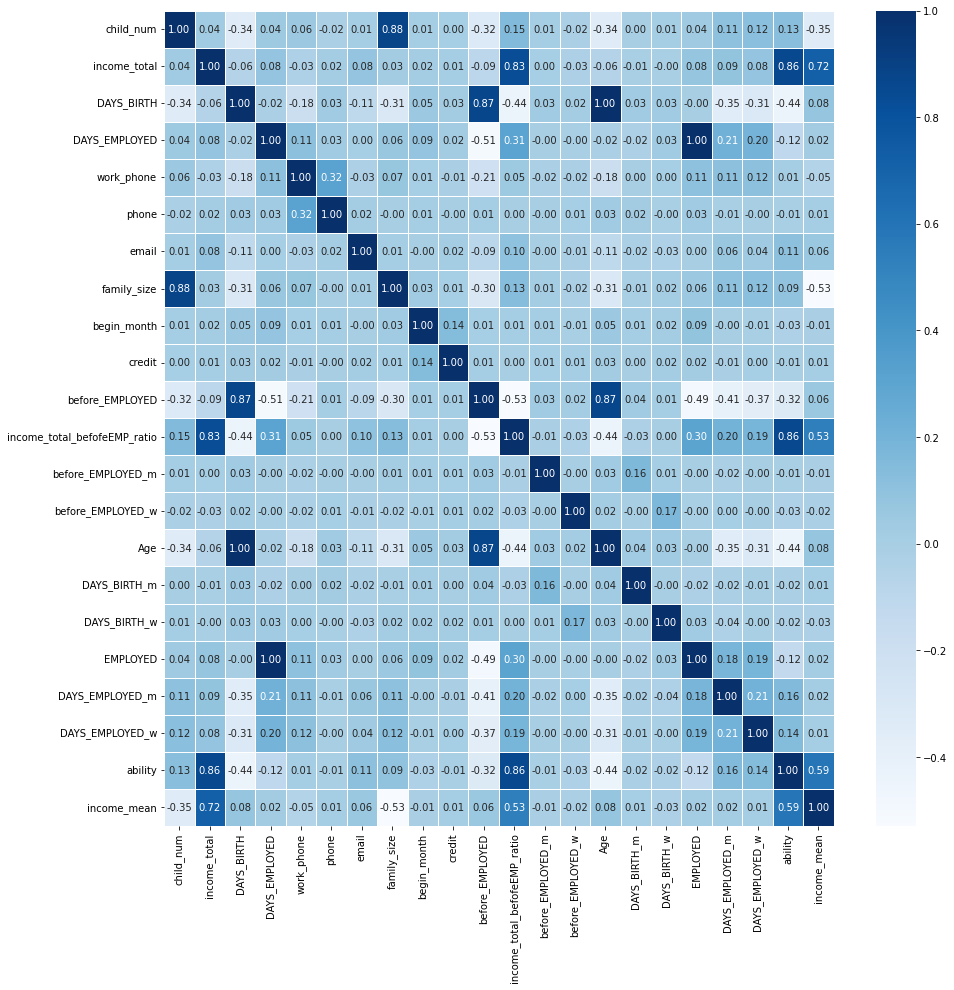

In [10]:
corr = train.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

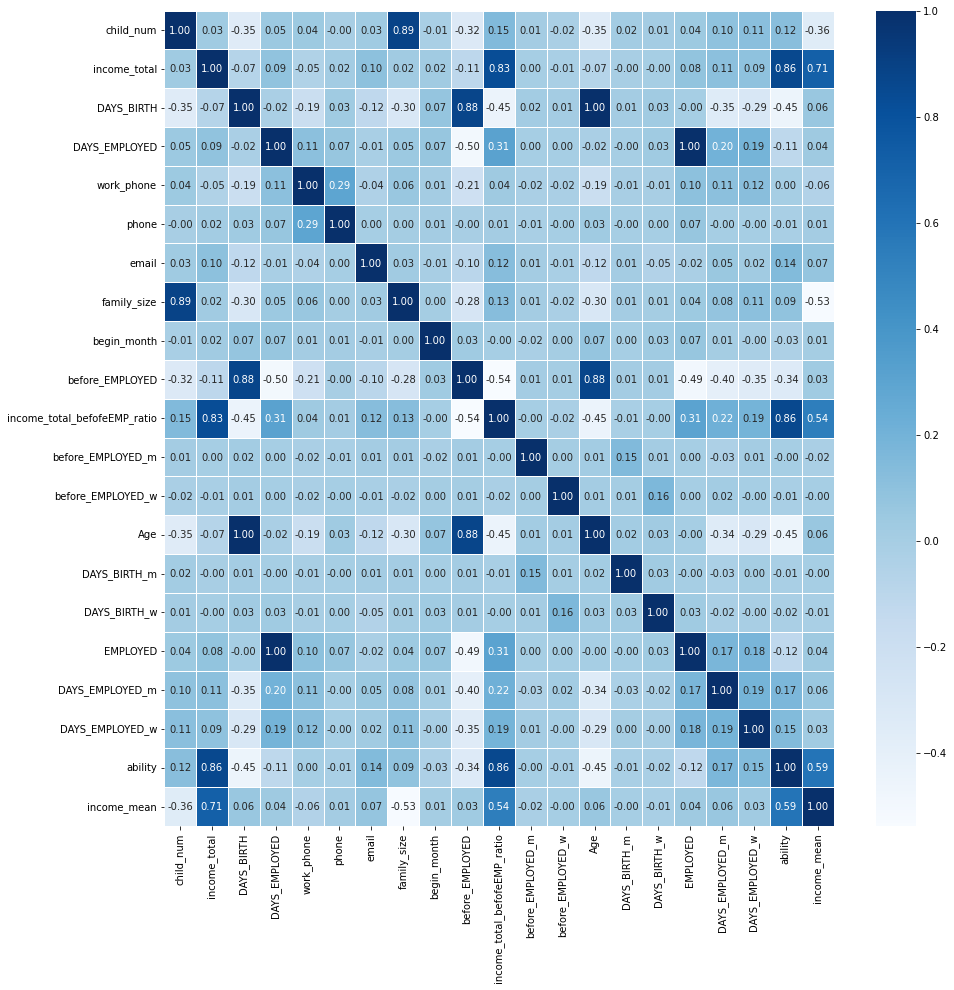

In [11]:
test_corr = test.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=test_corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

### **파생변수와 다중공선을 보이는 컬럼 삭제**

In [12]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
# df.drop(cols, axis=1, inplace=True)
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## **Scaling, Encoding**

### **1. Numerical, Categorical 컬럼 분류**

In [13]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()

numerical_feats.remove('credit')
numerical_feats.remove('work_phone')
numerical_feats.remove('phone')
numerical_feats.remove('email')

print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
categorical_feats.append('work_phone')
categorical_feats.append('phone')
categorical_feats.append('email')
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  15
Number of Categorical features:  11


In [14]:
numerical_feats

['income_total',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [15]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'work_phone',
 'phone',
 'email']

### **2. Log Scaling**

*   income_total



In [16]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### **3. Standard Scaling**

* 이미 로그스케일링을 진행한 income_total을 제외한 나머지 수치형 컬럼 정규화

In [17]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

### **4. One-hot Encoding**

In [17]:
# train = pd.get_dummies(train, columns = categorical_feats)
# test = pd.get_dummies(test, columns = categorical_feats)

## **Over Sampling**

* target이 imbalanced하기에 오버 샘플링 진행
* SMOTE, BoderlineSMOTE, ADASYN 적용 결과 SMOTE가 가장 성능이 좋아서 SMOTE 채택

In [18]:
X_train = train.drop(labels=['credit'], axis=1)
y_train = train['credit']

In [19]:
X_train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED',
       'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean'],
      dtype='object')

In [21]:
categorical_indexes = []
for c in categorical_feats:
    categorical_indexes.append(X_train.columns.get_loc(c))
categorical_indexes

[0, 1, 2, 4, 5, 6, 7, 11, 8, 9, 10]

In [22]:
# SMOTENC 모델 설정
smotenc = SMOTENC(categorical_features= categorical_indexes,random_state = 42, k_neighbors= 5)
X_train_res, y_train_res = smotenc.fit_resample(X_train, y_train)

print('Before Resampled dataset shape %s' % Counter(y_train))
print('After Resampled dataset shape %s' % Counter(y_train_res))

Before Resampled dataset shape Counter({2.0: 11028, 1.0: 4171, 0.0: 2172})
After Resampled dataset shape Counter({2.0: 11028, 1.0: 11028, 0.0: 11028})


In [23]:
y_train.value_counts()

2.0    11028
1.0     4171
0.0     2172
Name: credit, dtype: int64

In [24]:
y_train_res.value_counts()

2.0    11028
1.0    11028
0.0    11028
Name: credit, dtype: int64

## **Model - CatboostClassifier**

* fold 수를 5부터 17까지 돌려보고 최적 fold 5로 판단 후 선택



In [25]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

target = 'credit'
X = X_train_res
y = y_train_res
X_test = test

In [26]:
categorical_feats.remove('work_phone')
categorical_feats.remove('phone')
categorical_feats.remove('email')

In [28]:
from sklearn.metrics import classification_report

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], 1))
cat_pred_test = np.zeros((X_test.shape[0], 1))

cat_pred_proba = np.zeros((X.shape[0], n_class))
cat_pred_proba_test = np.zeros((X_test.shape[0], n_class))


# cat_cols = ['income_type','edu_type','family_type','house_type', 'occyp_type']
for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)

#   train_data = Pool(data=X_train, label=y_train)
#   valid_data = Pool(data=X_valid, label=y_valid)

  model_cat = CatBoostClassifier(n_estimators=n_est, random_seed=seed, bootstrap_type ='Bernoulli')
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict(X_valid)

  cat_pred_proba[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_proba_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred_proba[valid_idx]):.6f}')
  time.sleep(1)
  
print(f'\nLog Loss: {log_loss(y, cat_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

Learning rate set to 0.088468
0:	learn: 1.0897827	test: 1.0908781	best: 1.0908781 (0)	total: 115ms	remaining: 3m 49s
100:	learn: 0.8943657	test: 0.9160105	best: 0.9160105 (100)	total: 2.46s	remaining: 46.2s
200:	learn: 0.7827805	test: 0.8218010	best: 0.8218010 (200)	total: 4.54s	remaining: 40.7s
300:	learn: 0.7087619	test: 0.7617611	best: 0.7617611 (300)	total: 6.95s	remaining: 39.2s
400:	learn: 0.6564569	test: 0.7232367	best: 0.7232367 (400)	total: 10.3s	remaining: 41.3s
500:	learn: 0.6155345	test: 0.6945653	best: 0.6945653 (500)	total: 12.9s	remaining: 38.7s
600:	learn: 0.5805130	test: 0.6708420	best: 0.6708420 (600)	total: 15s	remaining: 35s
700:	learn: 0.5531969	test: 0.6544763	best: 0.6544763 (700)	total: 17s	remaining: 31.4s
800:	learn: 0.5295760	test: 0.6400174	best: 0.6400174 (800)	total: 19.1s	remaining: 28.7s
900:	learn: 0.5081152	test: 0.6277277	best: 0.6277277 (900)	total: 21.2s	remaining: 25.9s
1000:	learn: 0.4889456	test: 0.617

CV Log Loss Score: 0.547850

----------------- Fold 4 -----------------

Learning rate set to 0.088469
0:	learn: 1.0904649	test: 1.0906624	best: 1.0906624 (0)	total: 51.4ms	remaining: 1m 42s
100:	learn: 0.8927046	test: 0.9058730	best: 0.9058730 (100)	total: 2.68s	remaining: 50.4s
200:	learn: 0.7812940	test: 0.8092425	best: 0.8092425 (200)	total: 4.68s	remaining: 41.9s
300:	learn: 0.7088817	test: 0.7502661	best: 0.7502661 (300)	total: 7.08s	remaining: 40s
400:	learn: 0.6590716	test: 0.7120461	best: 0.7120461 (400)	total: 10.1s	remaining: 40.3s
500:	learn: 0.6184552	test: 0.6829780	best: 0.6829780 (500)	total: 12.1s	remaining: 36.3s
600:	learn: 0.5849006	test: 0.6598650	best: 0.6598650 (600)	total: 14.5s	remaining: 33.8s
700:	learn: 0.5577501	test: 0.6428560	best: 0.6428560 (700)	total: 16.5s	remaining: 30.6s
800:	learn: 0.5341496	test: 0.6275753	best: 0.6275753 (800)	total: 18.8s	remaining: 28.2s
900:	learn: 0.5105297	test: 0.6138856	best: 0.6138856 (900)	total: 20.8s	remaining: 25.4s
1

## **Model(Catboost) 평가**

### 1) Valid data 평가

In [29]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, cat_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, cat_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, cat_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, cat_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, cat_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, cat_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, cat_pred, normalize='true'))


Valid Accuracy Score: 0.800145
Valid F1 Score:  0.799403
Valid Log Loss: 0.548528

Valid ROC_AUC_Score: 0.916199

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83     11028
         1.0       0.82      0.71      0.76     11028
         2.0       0.74      0.87      0.80     11028

    accuracy                           0.80     33084
   macro avg       0.81      0.80      0.80     33084
weighted avg       0.81      0.80      0.80     33084


Confusion_matrix - valid data
[[9025  768 1235]
 [1094 7815 2119]
 [ 502  894 9632]]

Confusion_matrix_Normalize - valid data
[[0.81837142 0.06964091 0.11198767]
 [0.09920203 0.70865071 0.19214726]
 [0.04552049 0.08106638 0.87341313]]


### **Validation Set Confusion Matrix 시각화**

In [30]:
cat_cm = confusion_matrix(y,cat_pred)

cat_cm_df = pd.DataFrame(cat_cm, index = ['0','1','2'], columns = ['0','1','2'])

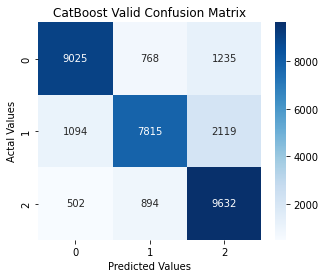

In [31]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cat_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [32]:
cat_cm_normalize = confusion_matrix(y,cat_pred, normalize='true')

cat_normalize_cm_df = pd.DataFrame(cat_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

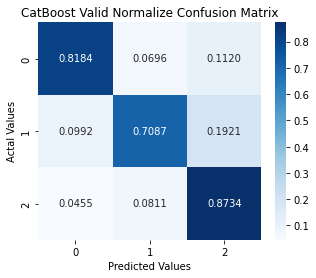

In [33]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(cat_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('CatBoost Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2) Test data 평가**

In [34]:
# Test Score
cat_pred_test = model_cat.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, cat_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, cat_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, cat_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, cat_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, cat_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, cat_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, cat_pred_test, normalize='true'))


Test Accuracy Score: 0.678216
Test F1 Score:  0.513691
Test Log Loss: 0.775690

Test ROC_AUC_Score: 0.715213

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.41      0.22      0.29       888
         1.0       0.54      0.40      0.46      1762
         2.0       0.73      0.87      0.79      4796

    accuracy                           0.68      7446
   macro avg       0.56      0.50      0.51      7446
weighted avg       0.65      0.68      0.65      7446


Confusion_matrix - Test data
[[ 199  134  555]
 [  96  698  968]
 [ 192  451 4153]]

Confusion_matrix_Normalize - Test data
[[0.2240991  0.1509009  0.625     ]
 [0.05448354 0.39614075 0.54937571]
 [0.04003336 0.0940367  0.86592994]]


### **Test Set Confusion Matrix 시각화**

In [35]:
cat_cm_test = confusion_matrix(y_test,cat_pred_test)

cat_cm_test_df = pd.DataFrame(cat_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

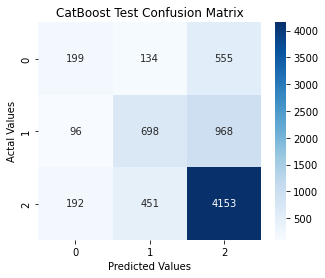

In [36]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cat_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [37]:
cat_cm_test_normalize = confusion_matrix(y_test, cat_pred_test, normalize='true')

cat_normalize_cm_test_df = pd.DataFrame(cat_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

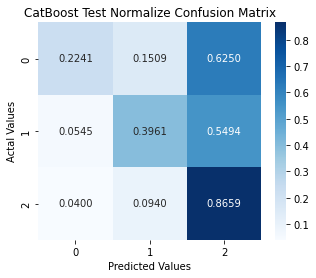

In [38]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(cat_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('CatBoost Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **Feature Importance**

In [39]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

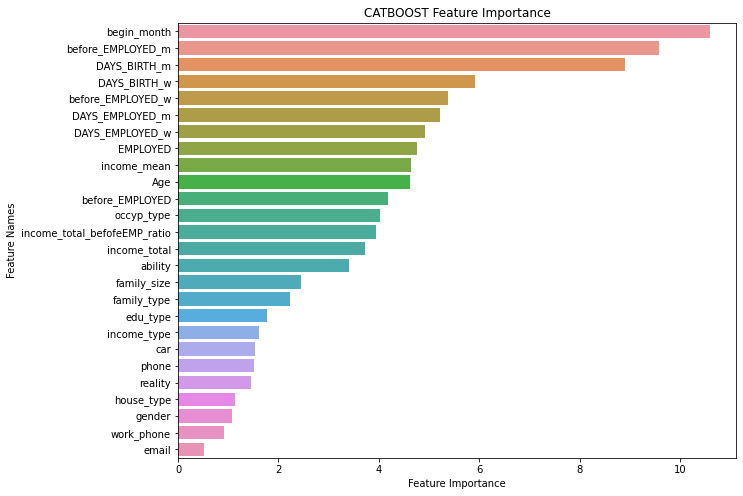

In [41]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [42]:
! pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [43]:
# shapley
import shap

In [44]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(Pool(X, y, cat_features=categorical_feats))

In [45]:
X.values[0]

array(['F', 'N', 'Y', 11.302229124707774, 'Commercial associate',
       'Secondary / secondary special', 'Single / not married',
       'House / apartment', 0, 0, 0, 'Medicine staff', -1.326970802599187,
       -0.661117092405982, -1.324681695457857, -0.428701082915246,
       -1.011765067049687, -1.3431247747261195, -1.4043629655586916,
       -0.42619118818297475, -0.4462511576286325, 0.2103065043824938,
       -0.6905580697804143, -0.22039546913354557, -0.6776203969867124,
       -0.27636632583193366], dtype=object)

In [46]:
X.iloc[0]

gender                                                      F
car                                                         N
reality                                                     Y
income_total                                        11.302229
income_type                              Commercial associate
edu_type                        Secondary / secondary special
family_type                              Single / not married
house_type                                  House / apartment
work_phone                                                  0
phone                                                       0
email                                                       0
occyp_type                                     Medicine staff
family_size                                         -1.326971
begin_month                                         -0.661117
before_EMPLOYED                                     -1.324682
income_total_befofeEMP_ratio                        -0.428701
before_E

In [47]:
y.iloc[0]

2.0

## SHAP Explanation Force Plots 

-	화살표가 클수록 output에 미치는 영향도 커짐

In [48]:
# SHAP Explanation Force Plots 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X.iloc[0], feature_names = X.columns)

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X.iloc[0], feature_names = X.columns)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X.iloc[0], feature_names = X.columns)

## SHAP waterfall plot

-	예측을 높게 해주는 변수는 빨간색으로 표시하고, 예측을 낮게 해주는 변수는 파란색으로 표시
-	학습 데이터셋에 대한 평균 모델 결과값으로부터 산출된 모델 결과를 최종 모델 결과로 산출하는 것에 대한 변수들의 공헌도

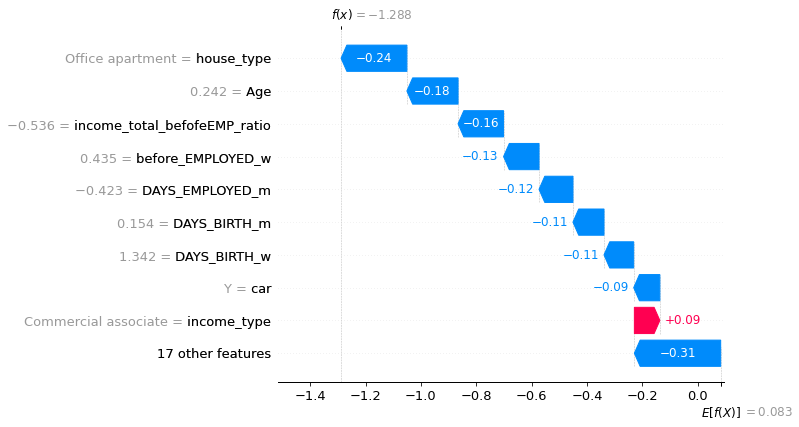

In [51]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

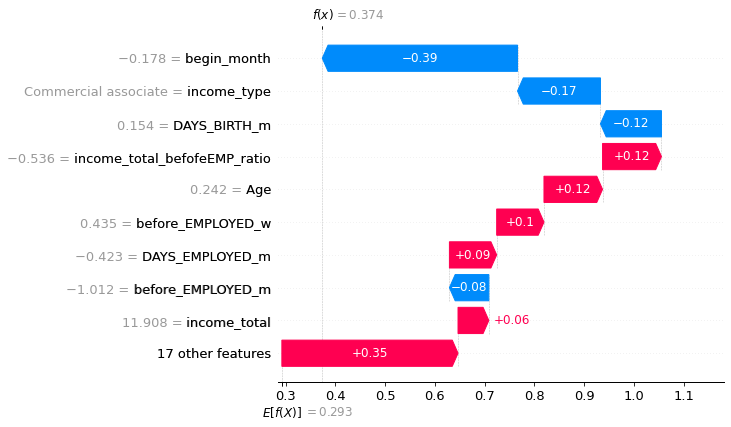

In [52]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

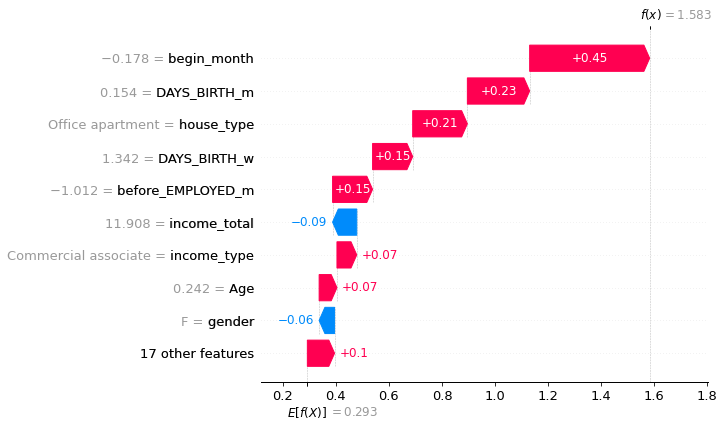

In [53]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[1], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

## SHAP Summary plot

-	feature importance와 feature effects 결합
-	전체 특성들이 Shapley value 분포에 어떤 영향을 미치는지 시각화하는 것
-	파란색 : 특성 값이 작다 / 빨간색 : 특성 값이 크다.
-	SHAP value가 큰 것 == 예측에 긍정적인 영향을 미친다.
> SHAP values : 가능한 모든 조합을 고려한 후 한 플레이어의 평균 기대 한계 기여도이다
-	‘begin_month’ column을 보면 특성값이 작을수록(파란색) 긍정적인 영향을 미치고 있다.

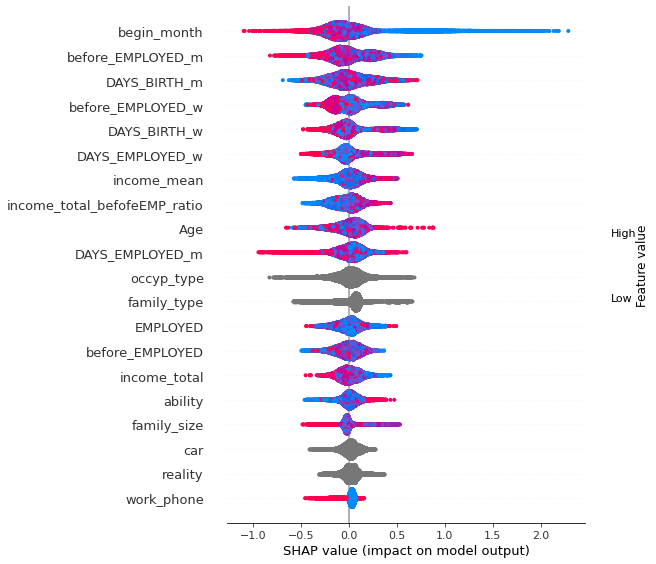

In [54]:
shap.summary_plot(shap_values[0], X)

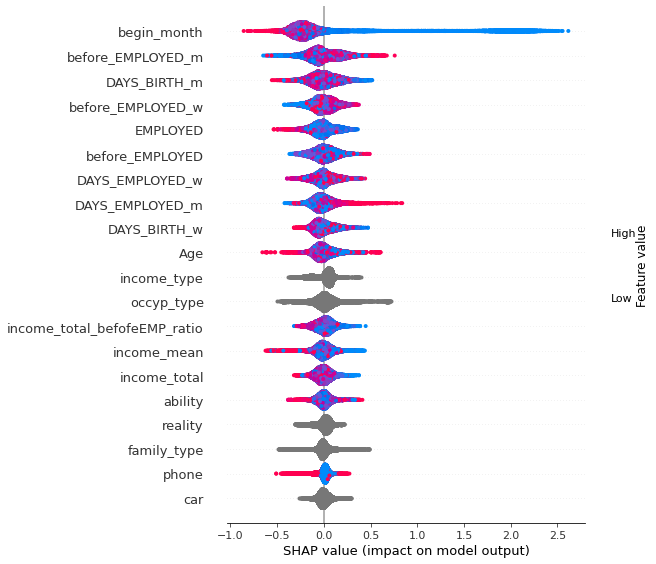

In [55]:
shap.summary_plot(shap_values[1], X)

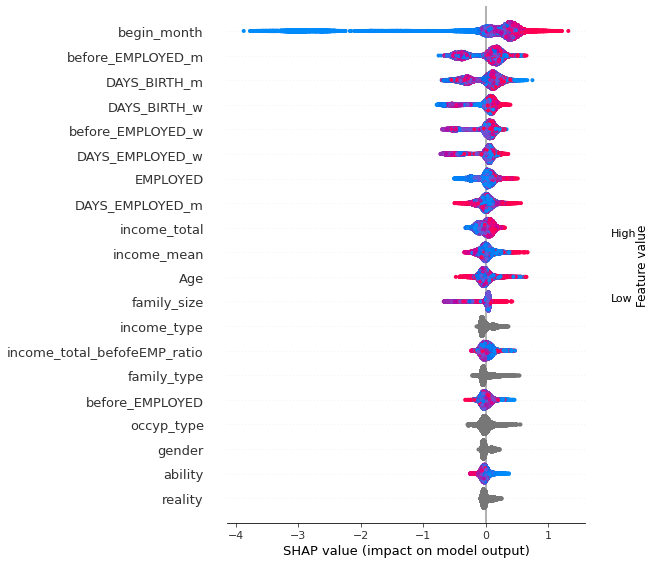

In [56]:
shap.summary_plot(shap_values[2], X)

## SHAP Feature Importance

-	summary_plot을 사용하되 파라미터로 plot_type을 정해주면 각 특성이 모델에 미치는 절대영향도(=기여분)을 눈으로 파악할 수 있다.

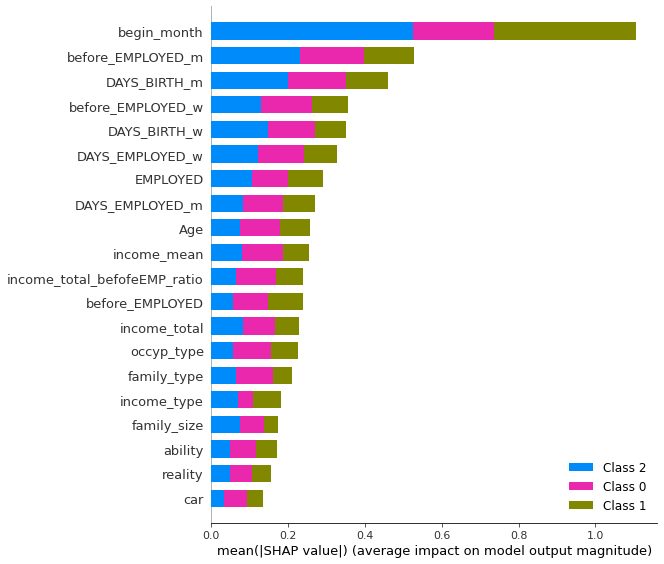

In [57]:
shap.summary_plot(shap_values, X)

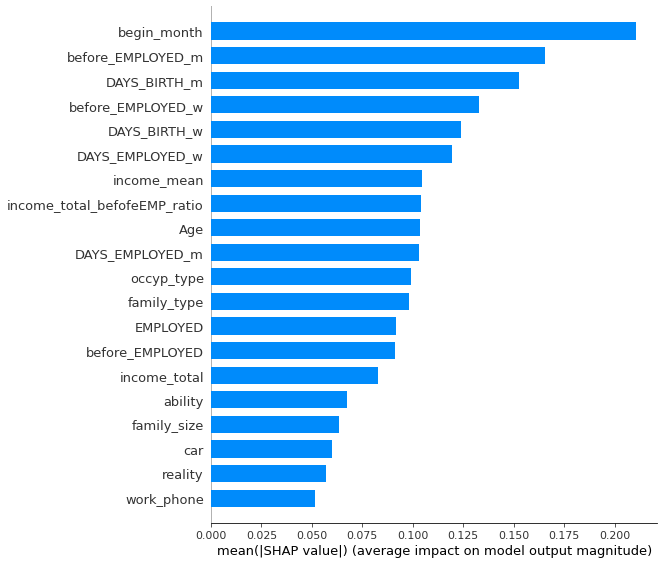

In [58]:
shap.summary_plot(shap_values[0], X, plot_type='bar')

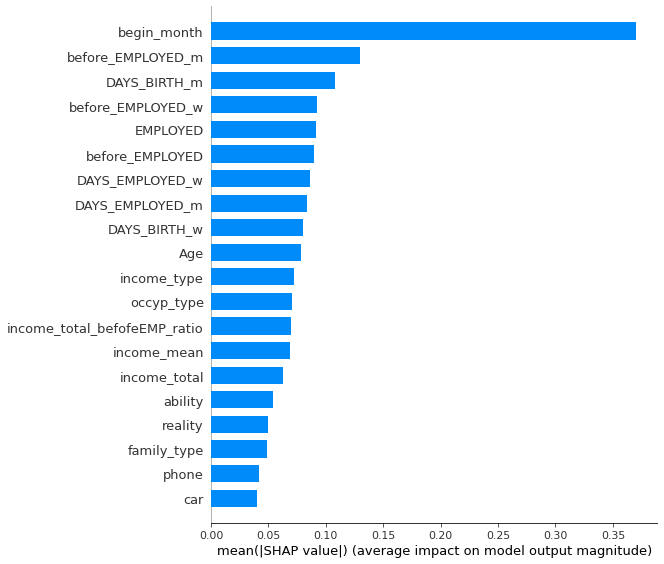

In [59]:
shap.summary_plot(shap_values[1], X, plot_type='bar')

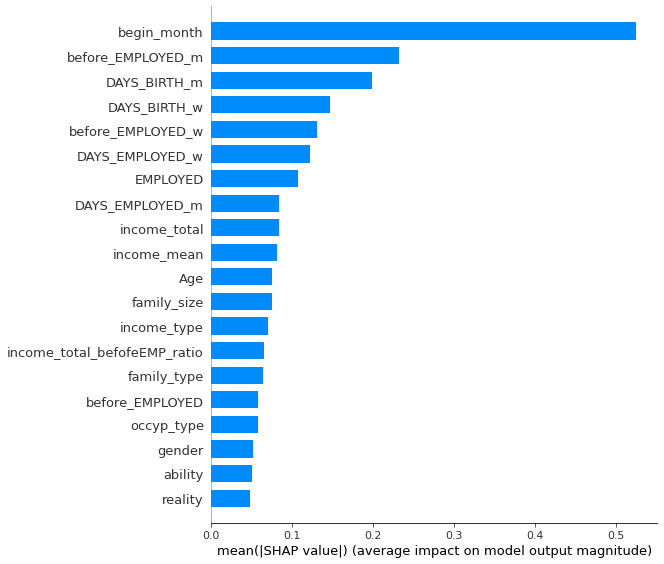

In [60]:
shap.summary_plot(shap_values[2], X, plot_type='bar')

## SHAP Dependence Plot

- dependence_plot 을 통해 각 특성의 Shapely value를 확인할 수 있음

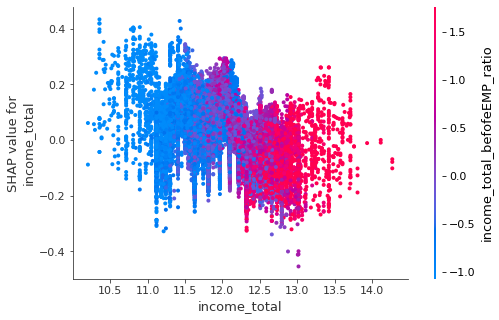

In [66]:
shap.initjs()
shap.dependence_plot(3, shap_values[0], X.values, feature_names=X.columns)

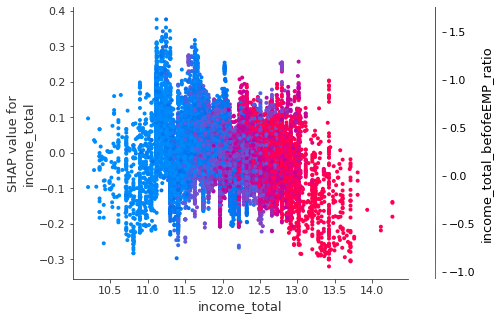

In [62]:
shap.dependence_plot(3, shap_values[1], X.values, feature_names=X.columns)